In [1]:
from shared.preface import *
import shared.functions as fct

### TODO: double check "beta" factor

### Values in Table 1 of Mertsch et al. (2020).

In [2]:
Rvir_Tab1 = fct.R_vir(0, Mvir_NFW)
print(Rvir_Tab1)
Rs_Tab1 = fct.scale_radius(0, Mvir_NFW)
print(Rs_Tab1)

5.231567088911345e+28
3.1216847097252106e+27


### Critical density of universe.

In [3]:
rho_crit_today = fct.rho_crit(0)
print(f'{rho_crit_today*(Msun/kpc**3)/(kg/m**3):.2e} kg/m^3') 

2.49e-39 kg/m^3


### Time Variable s(z) and comparison to age of universe.

In [4]:
# In s_of_z function we use
H0_mod = H0/ (1/s)
print(H0_mod)

test_z = 1
s_val = fct.s_of_z(test_z)
print(f'Value of time variable s in seconds at redhshift {test_z}:','\n', s_val)
print('Age of universe in seconds:','\n', t0/s, 1/H0/s)

2.1842852412351247e-18
Value of time variable s in seconds at redhshift 1: 
 5.0926383866523136e+17
Age of universe in seconds: 
 4.3478683200000006e+17 4.5781566487833824e+17


### Integrals for cosmic time.

In [5]:
def t_integrand_a(a):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M/a**3 + Omega_L)*H0_val*a
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_a, 0, 1)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

13.854185334518117 2.035514967021816e-12


In [6]:
def t_integrand_z(z):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M*(1.+z)**3 + Omega_L)*H0_val*(1.+z)
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_z, 0, np.inf)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

13.854185334518112 3.8804667681380004e-11


### Fermi-Dirac distribution.

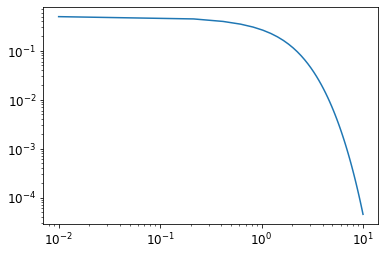

In [7]:
p_test_range = np.linspace(0.01, 10)*T_CNB
FD_range = fct.Fermi_Dirac(p_test_range)

plt.loglog(p_test_range/T_CNB, FD_range)
plt.show()

### Conversions between momentum and velocity (limits).

In [8]:
for m_eV in NU_MASSES:

    # Momentum limits (in units of T_CNB) to velocity limits (in km/s).
    v_lower = LOWER/m_eV / (km/s)
    v_upper = UPPER/m_eV / (km/s)
    print(v_lower, v_upper)

    # Velocity limits (in km/s) to momentum limits (in units of T_CNB).
    p_lower, y_lower = fct.u_to_p_eV(v_lower*(km/s)/(kpc/s), m_eV)
    p_upper, y_upper = fct.u_to_p_eV(v_upper*(km/s)/(kpc/s), m_eV)
    print(np.round(y_lower, 4), np.round(y_upper, 4), '\n')

50.37649475439018 503764.9475439018
0.01 100.0 

10.075298950878034 100752.98950878036
0.01 100.0 

5.037649475439017 50376.49475439018
0.01 100.0 

1.679216491813006 16792.16491813006
0.01 100.0 



## Redshift array for integration steps.

300 (300,)
0.0 4.0


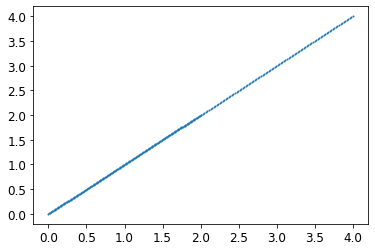

In [9]:
Z_START, Z_STOP, Z_AMOUNT = 0., 4., 199
Z_START_LOG = 1e-1
zeds_pre = np.geomspace(Z_START_LOG, Z_STOP, Z_AMOUNT) - Z_START_LOG
ZEDS = np.insert(zeds_pre, len(zeds_pre), 4.)

z_early = np.linspace(0,2,200)
z_late = np.linspace(2.01,4,100)

zeds_test = np.concatenate((z_early, z_late))
print(len(zeds_test), zeds_test.shape)
print(zeds_test[0], zeds_test[-1])

plt.scatter(zeds_test, zeds_test, s=1)
plt.show()

(300,)
0.0 4.0


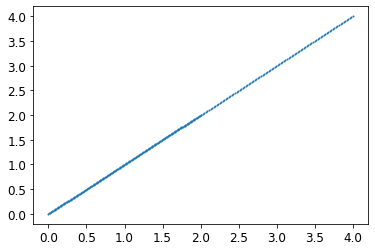

In [13]:
late_steps = 1000
early_steps = 100
Z_START, Z_STOP, Z_AMOUNT = 0., 4., late_steps+early_steps
z_late = np.linspace(0,2,200)
z_early = np.linspace(2.01,4,100)
ZEDS = np.concatenate((z_late, z_early))

print(ZEDS.shape)
print(ZEDS[0], ZEDS[-1])

plt.scatter(ZEDS, ZEDS, s=1)
plt.show()